In [1]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.cloud import bigquery

os.environ["GOOGLE_APPLICATION_CREDENTIALS"]="../esoteric-bruin-379522-1ac227ab6db1.json"
client = bigquery.Client()

pd.set_option('display.max_columns', None)

In [2]:
# 1.1 Przygotuj dane, które będą Ci potrzebne do przewidzenia nowych przypadków COVID-19 i przefiltruj je, 
# aby uwzględnić tylko interesujący Cię okres czasu (np.rok 2022, I i II kw. 2021).
sql = """
    select
    new_confirmed, date, new_deceased, new_persons_vaccinated
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2021-09-01' and '2022-03-01'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
df = query_result.to_dataframe()
df

,new_confirmed,date,new_deceased,new_persons_vaccinated
0,390,2021-09-01,7,22597
1,349,2021-09-02,5,24677
2,389,2021-09-03,7,29381
3,324,2021-09-04,0,18897
4,183,2021-09-05,0,11528
...,...,...,...,...
177,8902,2022-02-25,221,6344
178,6564,2022-02-26,40,3290
179,12984,2022-02-27,1,463
180,14737,2022-02-28,269,3281


In [3]:
## Prawdziwe dane do przewidywań tv
sql = """
    select
    date, new_confirmed, new_deceased, new_persons_vaccinated
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2022-03-02' and '2022-03-29'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
tv = query_result.to_dataframe()


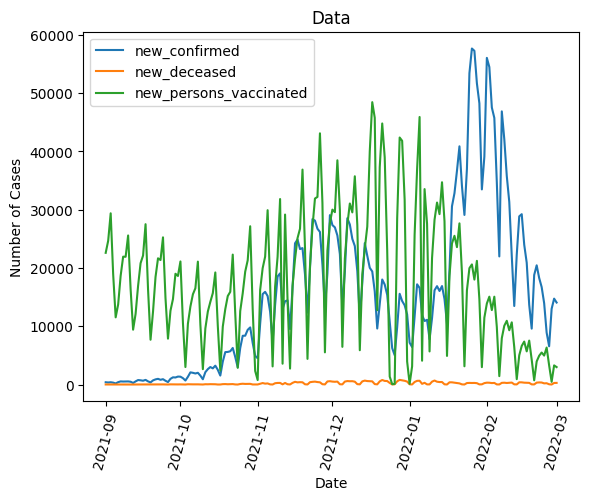

In [4]:
#Przedstawienie na wykresie pobranych danych
plt.plot(df['date'], df['new_confirmed'], label ='new_confirmed')
plt.plot(df['date'], df['new_deceased'], label ='new_deceased')
plt.plot(df['date'], df['new_persons_vaccinated'], label ='new_persons_vaccinated')
plt.xticks(rotation=75)
plt.xlabel('Date')
plt.ylabel('Number of Cases')
plt.title('Data')
plt.legend(loc = 2)
plt.show()

In [5]:
#1.2 przygotowanie do analizy regresji liniowej
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime as dt
df['date'] = pd.to_datetime(df['date'])
df['date']=df['date'].map(dt.datetime.toordinal)
df

,new_confirmed,date,new_deceased,new_persons_vaccinated
0,390,738034,7,22597
1,349,738035,5,24677
2,389,738036,7,29381
3,324,738037,0,18897
4,183,738038,0,11528
...,...,...,...,...
177,8902,738211,221,6344
178,6564,738212,40,3290
179,12984,738213,1,463
180,14737,738214,269,3281


In [6]:
# przewidywanie dla następnych 4 tygodni
# regresja liniowa
def linear_prediction(df, colname):
    lr = LinearRegression()
    lr.fit(df[['date']].values.reshape(-1,1),df[colname])
    # Zastosowanie analizy regresji, aby przewidzieć liczbę nowych przypadków w kolejnych tygodniach
    predicted_data = pd.DataFrame({'date':pd.date_range('2022-03-02', periods=28)})
    predicted_data['date'] = pd.to_datetime(predicted_data['date'])
    predicted_data['date'] = predicted_data['date'].map(dt.datetime.toordinal)
    pred = lr.predict(predicted_data['date'].values.reshape(-1,1))
    predicted_data[f"predicted_+ {colname}"] = pred
    predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)


    #plot
    plt.plot(predicted_data['date'], predicted_data[f"predicted_+ {colname}"])
    #plt.plot(tv['date'], tv['new_confirmed'])
    plt.xticks(rotation=75)
    plt.xlabel('Date')
    plt.ylabel(f"Predicted {colname}")
    plt.title(f"Predicted {colname}")
    plt.show()
    return predicted_data, lr

In [7]:
# funkcja która znajduję nalepszy stopień wielomianu sprawdzając średni błąd kwadratowy

from sklearn.metrics import mean_squared_error
def find_best_degree(tdf, xcolname):
    # Split the data into training and test sets
    train_size = int(0.8 * len(tdf))
    train_data = tdf[:train_size]
    test_data = tdf[train_size:]

    # Define the range of degrees to consider
    degrees = [2, 3, 4, 5]

    # Prepare the data
    X_train = train_data.reset_index().index.values.reshape(-1, 1)
    y_train = train_data[xcolname].values
    X_test = test_data.reset_index().index.values.reshape(-1, 1)
    y_test = test_data[xcolname].values

    best_degree = None
    best_rmse = float('inf')
    # RMSE - Średni błąd kwadratowy


    # Iterowanie po stopniach wielomianu i dopasowywanie
    for degree in degrees:

        poly_features = PolynomialFeatures(degree=degree)
        X_train_poly = poly_features.fit_transform(X_train)
        X_test_poly = poly_features.transform(X_test)

        # dopasowanie
        model = LinearRegression()
        model.fit(X_train_poly, y_train)

        # ocena
        y_train_pred = model.predict(X_train_poly)
        train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
        y_test_pred = model.predict(X_test_poly)
        test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))

#         print(f"Degree: {degree}")
#         print(f"Training RMSE: {train_rmse}")
#         print(f"Test RMSE: {test_rmse}")
#         print(f"Predicted: {y_test_pred}")
#         print()

        # ocena najlepszego stopnia bazujac na testowym RMSE
        if test_rmse < best_rmse:
            best_rmse = test_rmse
            best_degree = degree

    print(f"Best degree: {best_degree}")
    return best_degree


In [8]:
#1.3 Użyj regresji wielomianowej jako rozszerzenia regresji liniowej, który pozwala na modelowanie związku pomiędzy zmiennymi
# niezależnymi, a zmienną zależną za pomocą wielomianu. W regresji wielomianowej zastosowanie wielomianów wyższych stopni
# pozwala na uwzględnienie nieliniowych związków między zmiennymi niezależnymi (np. czasem) a zmienną zależną  (np. liczbą 
# nowych przypadków). Aby dobrać odpowiedni stopień wielomianu, można przeprowadzić walidację krzyżową lub podzielić dane
# na zbiory treningowe i testowe, a następnie obliczyć metryki błędów dla różnych stopni wielomianów. Weź pod uwagę, że na
# liczbę nowych przypadków mogą wpływać inne czynniki takie jak np.: polityka rządowa (ograniczenia społeczne, noszenie
# maseczek), gęstość zaludnienia, dostęp do opieki zdrowotnej, struktura demograficzna, itd.

from sklearn.preprocessing import PolynomialFeatures

def poly_prediction(df, colname, predicted_data):
    best_degree = find_best_degree(df, colname)
    
    predicted_data['date'] = predicted_data['date'].map(dt.datetime.toordinal)
    pr = PolynomialFeatures(degree = best_degree, include_bias=False)
    X_poly = pr.fit_transform(df['date'].values.reshape(-1,1))
    lr2= LinearRegression()
    lr2.fit(X_poly,df[[colname]]) 

    pred2 = lr2.predict(pr.fit_transform(predicted_data[['date']]))
    predicted_data[f"predicted_+ {colname}"] = pred2
    predicted_data['date']=predicted_data['date'].map(dt.datetime.fromordinal)
    #df['date'] = df['date'].map(dt.datetime.fromordinal)


    plt.plot(predicted_data['date'], predicted_data[f"predicted_+ {colname}"])
    #plt.plot(tv['date'], tv['new_confirmed'])
    plt.xticks(rotation=75)
    plt.xlabel('Date')
    plt.ylabel(f'Predicted {colname}')
    plt.title(f'Predicted {colname}')
    plt.show()
    return predicted_data, lr2, pr


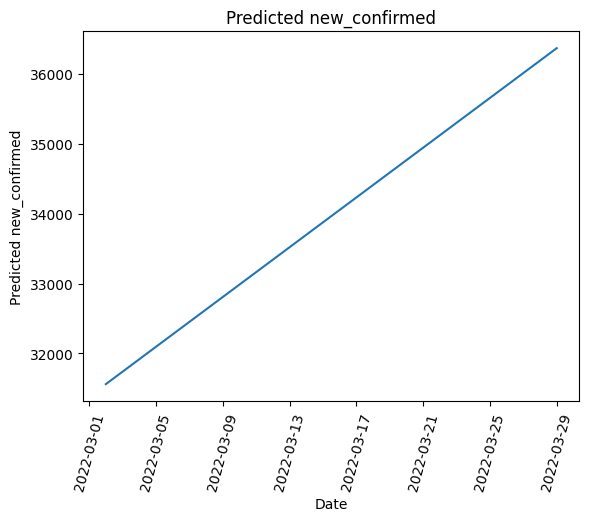

Best degree: 5


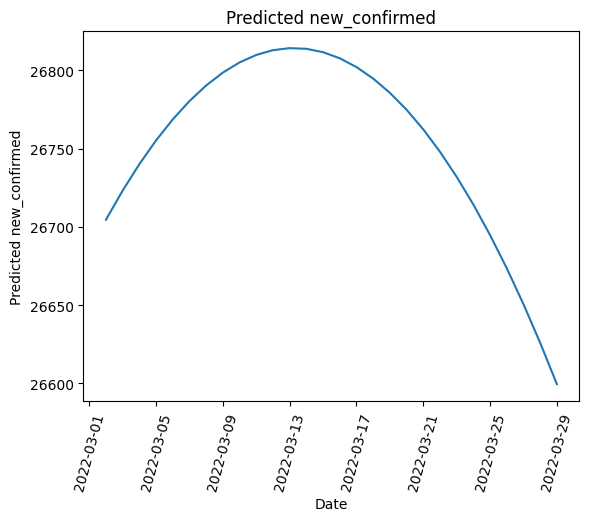

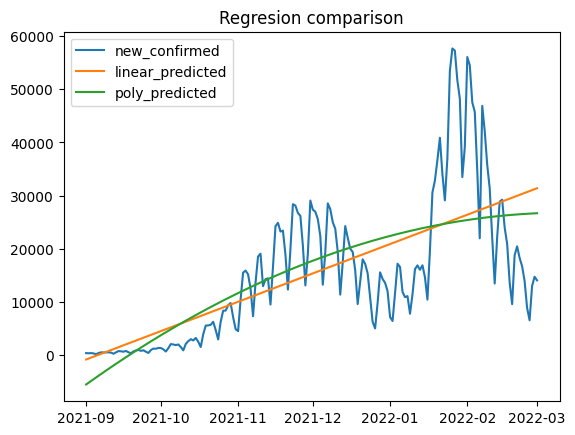

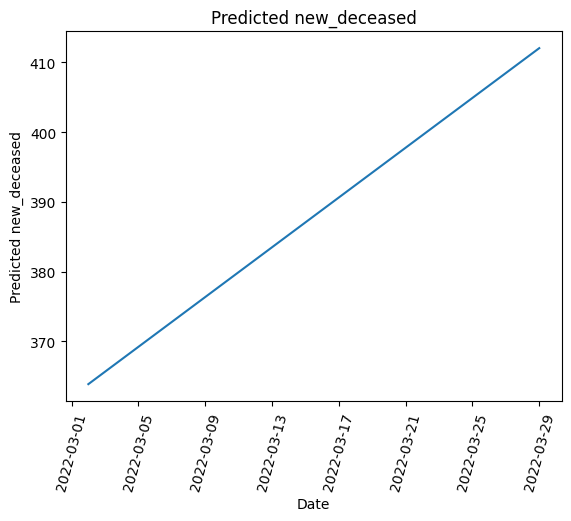

Best degree: 5


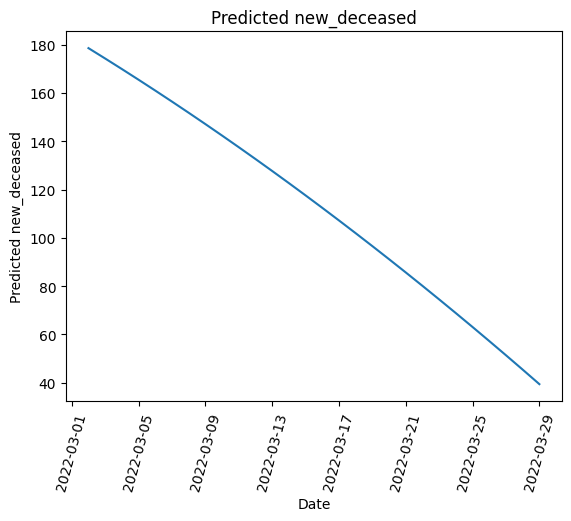

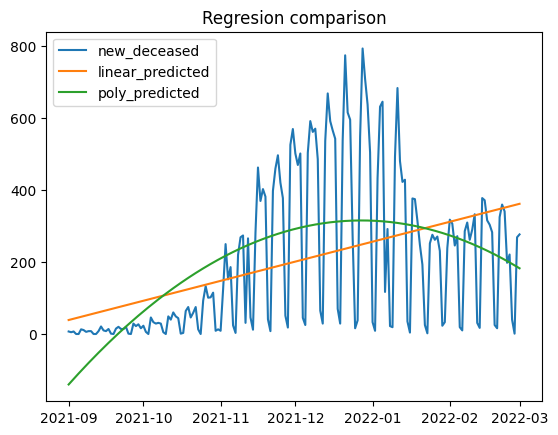

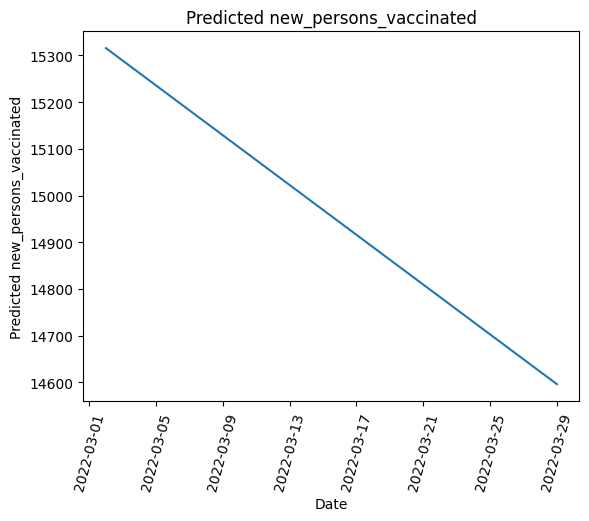

Best degree: 4


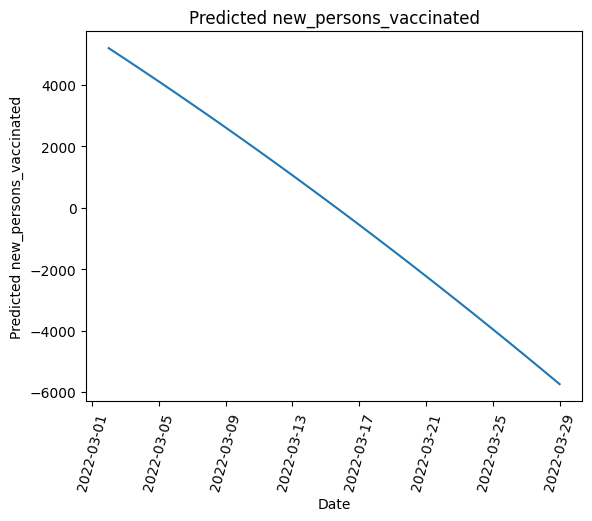

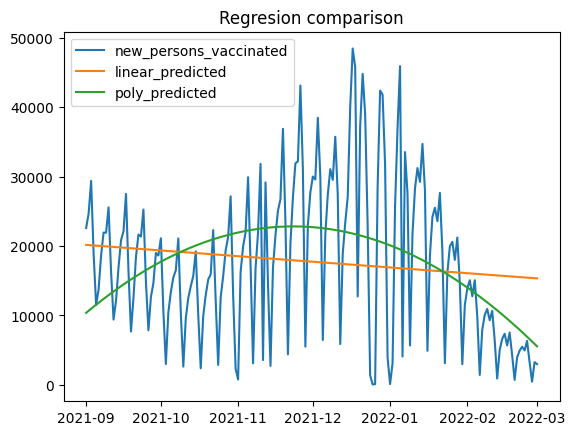

In [9]:
# wizualizacja przewidywań dla modelu liniowego i wielomianowego i wizualizacja modelu 
#dla zachorowań śmierci i szczepień

for col in ['new_confirmed', 'new_deceased', 'new_persons_vaccinated']:
    
    p_data, lidd = linear_prediction(df, col)
    pp_data, lidd2, pr = poly_prediction(df, col, p_data)
    
    # wykres porównawczy
    linear_predicted = lidd.predict(df['date'].values.reshape(-1,1))
    poly_predicted = lidd2.predict(pr.fit_transform(df[['date']]))
    df['date']=df['date'].map(dt.datetime.fromordinal)
    plt.plot(df['date'], df[col], label = col)
    plt.plot(df['date'], linear_predicted, label ='linear_predicted')
    plt.plot(df['date'], poly_predicted, label ='poly_predicted')
    plt.legend(loc = 2)
    plt.title("Regresion comparison")
    plt.show()
    df['date']=df['date'].map(dt.datetime.toordinal)

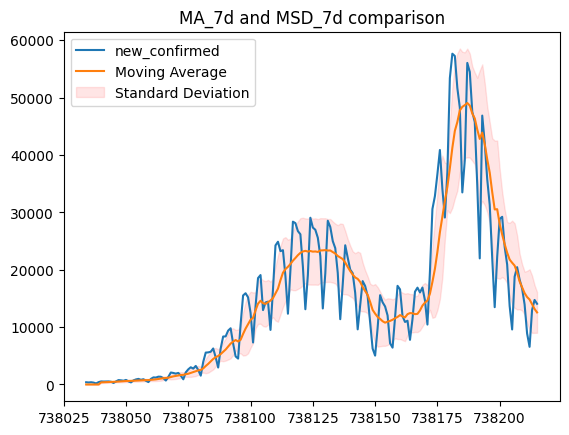

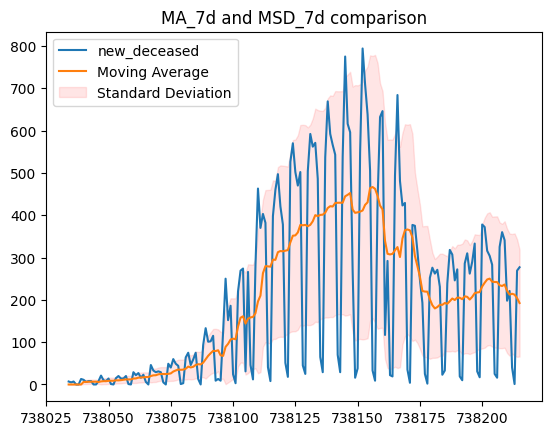

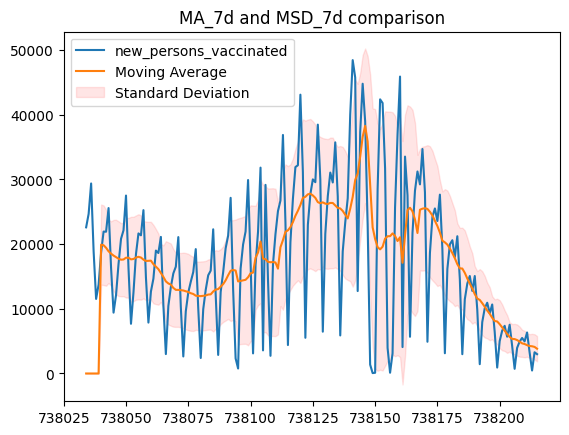

In [10]:
#2.1  Przeanalizuj trendy i zmiany w czasie dotyczące liczby nowych przypadków COVID-19.
#Spróbuj wyznaczyć średnią kroczącą i odchylenie standardowe kroczące (np. 7-dniowe), 
#dla tych zmiennych, aby zobaczyć, jak zjawiska te zmieniają się w czasie.
#Sprawdź, czy występują jakieś sezonowe wzorce lub cykle.

from statsmodels.tsa.seasonal import seasonal_decompose

for col in ['new_confirmed', 'new_deceased', 'new_persons_vaccinated']:
    #Średnia krocząca 7-dniowa
    df['Moving_Average'] = df[col].rolling(7).mean()

    #Odchylenie standardowe kroczace 7-dniowe
    df['Moving_Standart_Deviation'] = df[col].rolling(7).std()

    df[["Moving_Average","Moving_Standart_Deviation"]] = df[["Moving_Average","Moving_Standart_Deviation"]].fillna(0)

    plt.plot(df['date'], df[col], label =col)
    plt.plot(df['date'], df['Moving_Average'], label ='Moving Average')
    #plt.plot(df['date'], df['MSD_7d'], label ='MSD_7d')
    plt.fill_between(df['date'], df['Moving_Average'] - df['Moving_Standart_Deviation'], df['Moving_Average'] + df['Moving_Standart_Deviation'], alpha=0.1, color ="red",  label='Standard Deviation')
    plt.legend(loc = 2)
    plt.title("MA_7d and MSD_7d comparison")
    plt.show()

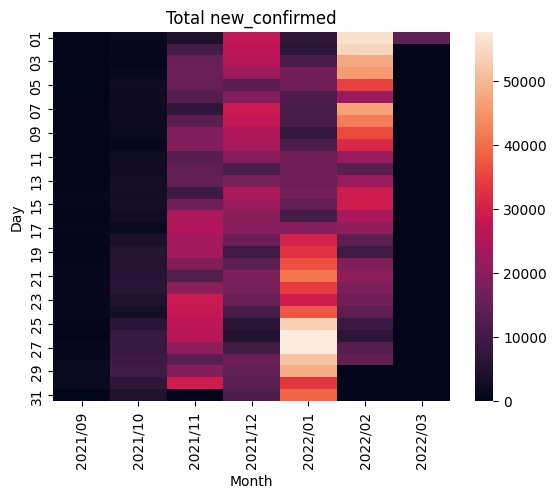

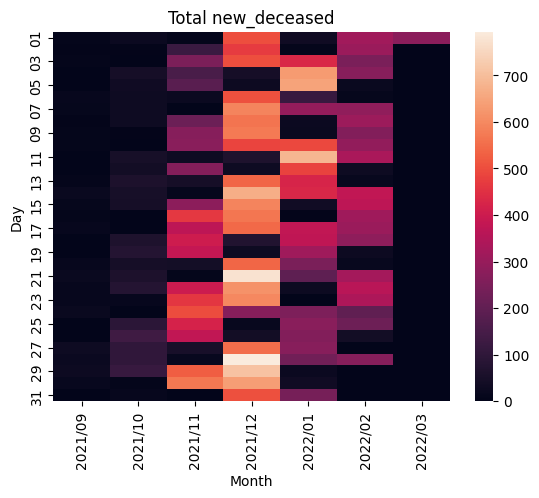

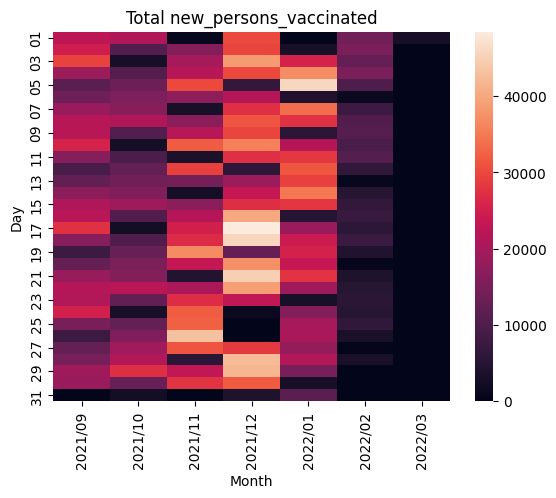

In [11]:
# Heatmapa dla rozłożenia ilości przyapdków w czasie
import seaborn as sns
df['date']=df['date'].map(dt.datetime.fromordinal)
df['Year_Month'] = df['date'].dt.strftime('%Y/%m')
df['Day'] = df['date'].dt.strftime('%d')
df
tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_confirmed")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_confirmed")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_deceased")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_deceased")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df.pivot_table(index="Day", columns="Year_Month", values="new_persons_vaccinated")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_persons_vaccinated")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

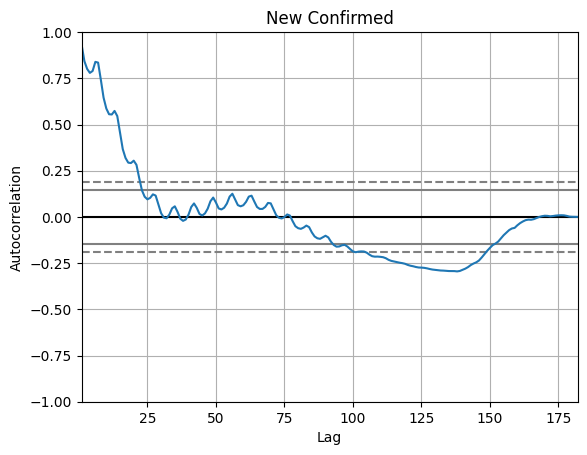

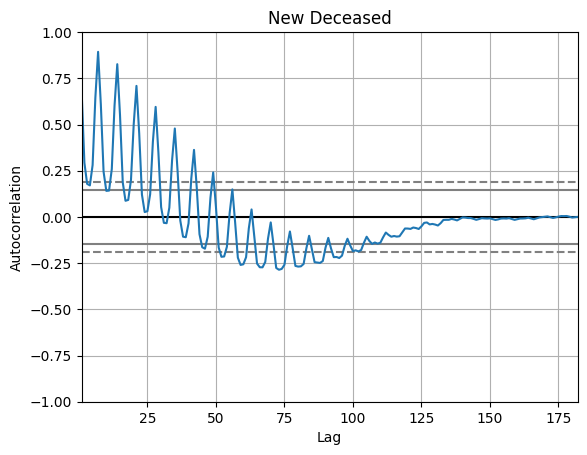

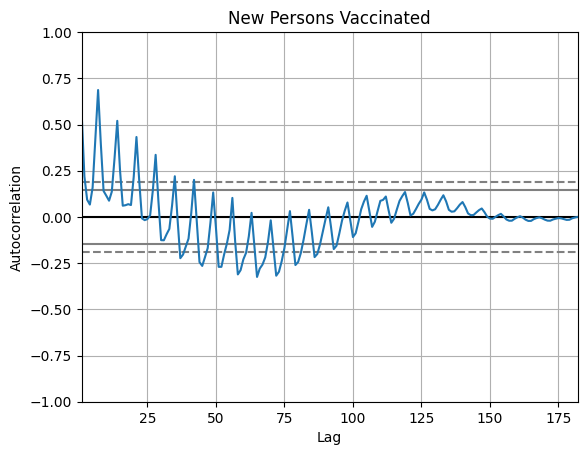

In [12]:
#2.2. Wykorzystaj do analizy trendów analizę szeregów czasowych (autoregresja, średnia ruchoma, modele autoregresyjne), 
#która umożliwi zbadanie danych zebranych w Twoich bazach w danym okresie czasu.
import seaborn as sns
# Wykres przedstawiający autokorelacje w całym okresie
# Autokorelacja informuje nas o tym na ile dane wartości / obserwacje są istotnie związane z obserwacjami
# zaobserwowanymi wcześniej (o stałym przesunięciu czasowym).
x = pd.plotting.autocorrelation_plot(df['new_confirmed'])
x.plot()
plt.title("New Confirmed")
plt.show()

x = pd.plotting.autocorrelation_plot(df['new_deceased'])
x.plot()
plt.title("New Deceased")
plt.show()

x = pd.plotting.autocorrelation_plot(df['new_persons_vaccinated'])
x.plot()
plt.title("New Persons Vaccinated")
plt.show()

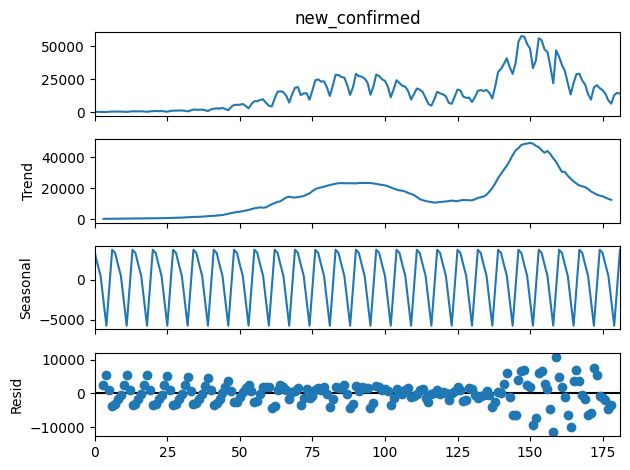

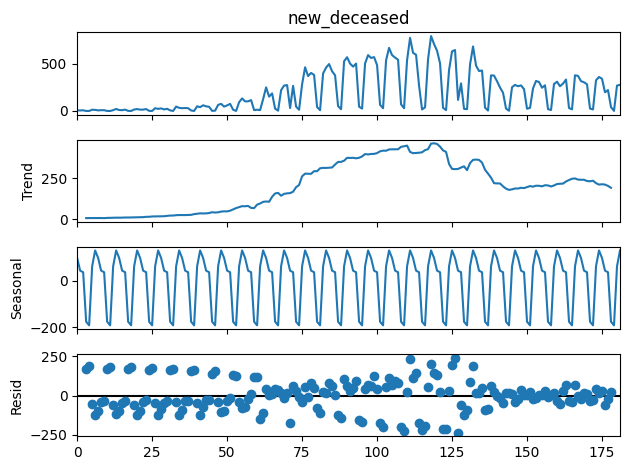

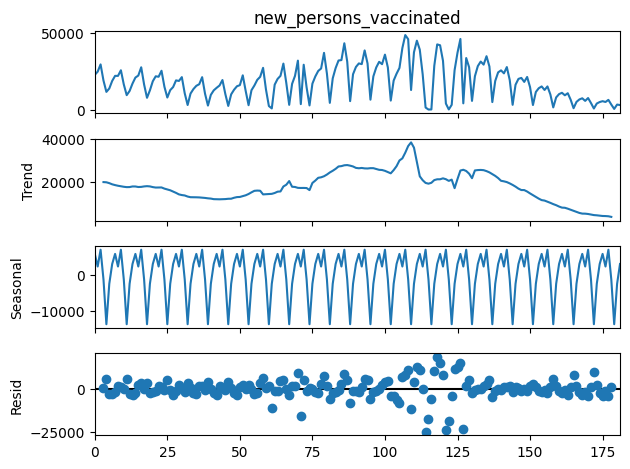

In [13]:
# Trend: Rosnąca lub malejąca wartość w szeregu. Jeśli linia trendu jest płaska lub oscyluje wokół pewnej wartości,
# oznacza to brak wyraźnego trendu
# Seasonality: Powtarzający się cykl krótkoterminowy w serii.
# Resid: Losowa zmienność w szeregu. Residual to to, co pozostaje po usunięciu trendu i sezonowości. Na przykład może
# istnieć pewien wzorzec autokorelacji szybko ewoluujący wokół wolno poruszającego się trendu oraz sezonowych wahań.
# Tego rodzaju wzorca nie można przypisać składnikowi trendu (ten pierwszy porusza się zbyt szybko) ani składnikowi sezonowemu
#(ten pierwszy nie przestrzega sezonowego harmonogramu). Zostaje więc w residual. 
decompose = seasonal_decompose(df['new_confirmed'],model='additive', period=7)
decompose.plot()
plt.show() #(df['new_confirmed'],model='additive', period=7)
decompose = seasonal_decompose(df['new_deceased'],model='additive', period=7)
decompose.plot()
plt.show()
decompose = seasonal_decompose(df['new_persons_vaccinated'],model='additive', period=7)
decompose.plot()
plt.show()

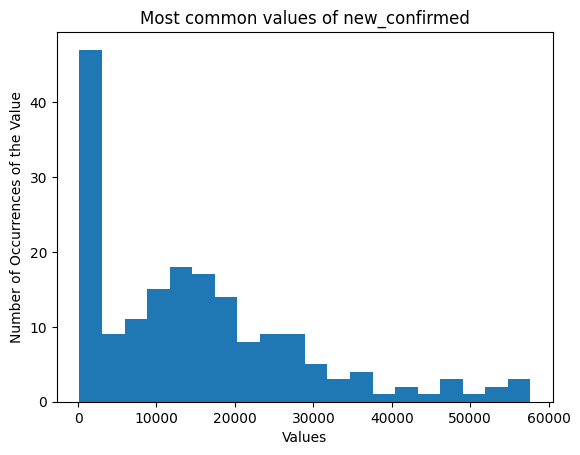

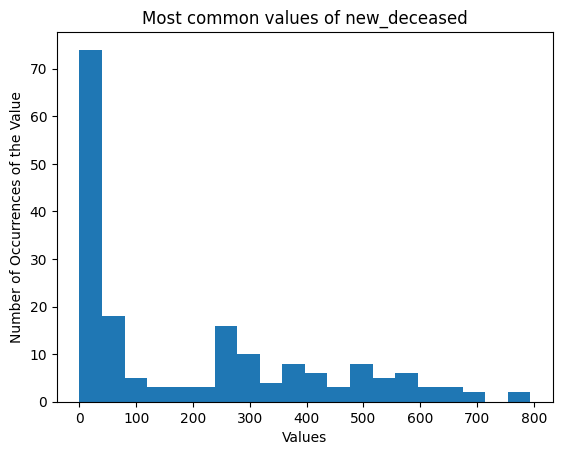

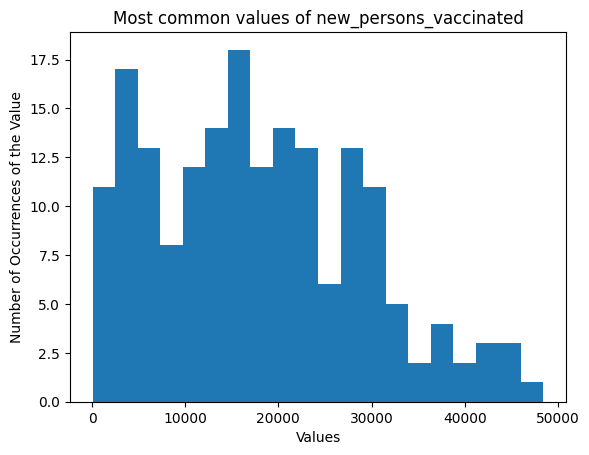

In [14]:
#Wykres rozłożenia wartosci new_confirmed
plt.hist(df['new_confirmed'], 20, histtype='bar')
plt.title("Most common values of new_confirmed")
plt.xlabel("Values")
plt.ylabel("Number of Occurrences of the Value")
plt.show()

plt.hist(df['new_deceased'], 20, histtype='bar')
plt.title("Most common values of new_deceased")
plt.xlabel("Values")
plt.ylabel("Number of Occurrences of the Value")
plt.show()

plt.hist(df['new_persons_vaccinated'], 20, histtype='bar')
plt.title("Most common values of new_persons_vaccinated")
plt.xlabel("Values")
plt.ylabel("Number of Occurrences of the Value")
plt.show()


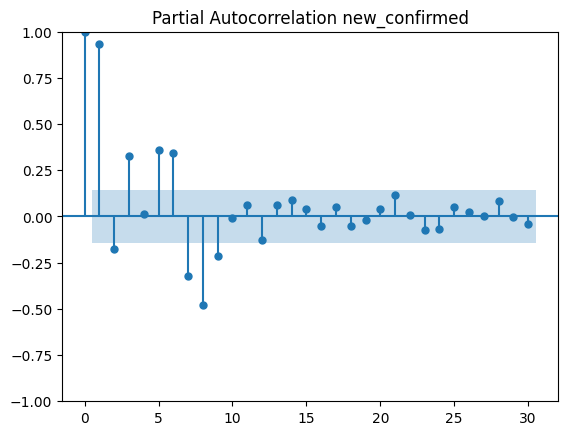

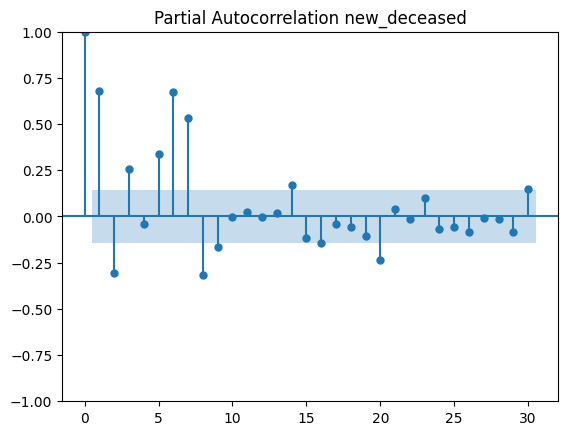

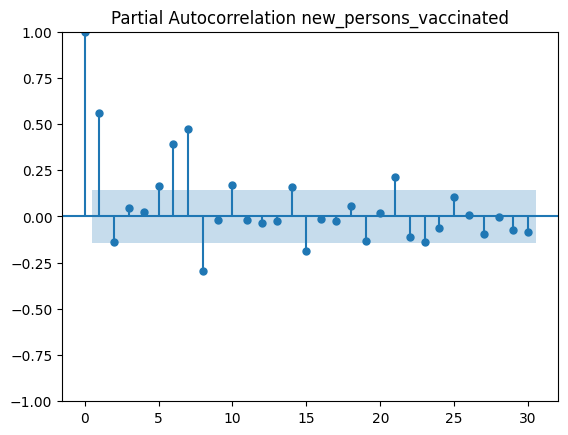

In [15]:
# Poniższy wykres może posłużyć do określenia dla jakiej wartości lags użyć autoregresji.
from statsmodels.graphics.tsaplots import plot_pacf

pacf = plot_pacf(df['new_confirmed'], lags=30)
plt.title("Partial Autocorrelation new_confirmed")
plt.show()
pacf = plot_pacf(df['new_deceased'], lags=30)
plt.title("Partial Autocorrelation new_deceased")
plt.show()
pacf = plot_pacf(df['new_persons_vaccinated'], lags=30)
plt.title("Partial Autocorrelation new_persons_vaccinated")
plt.show()

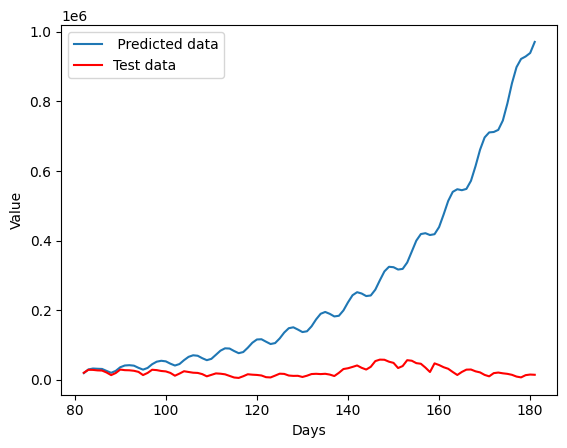

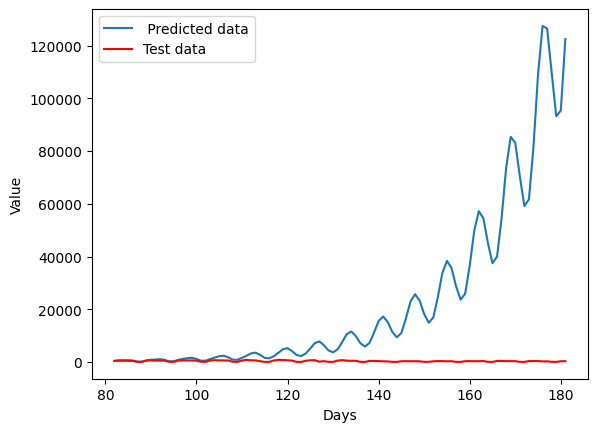

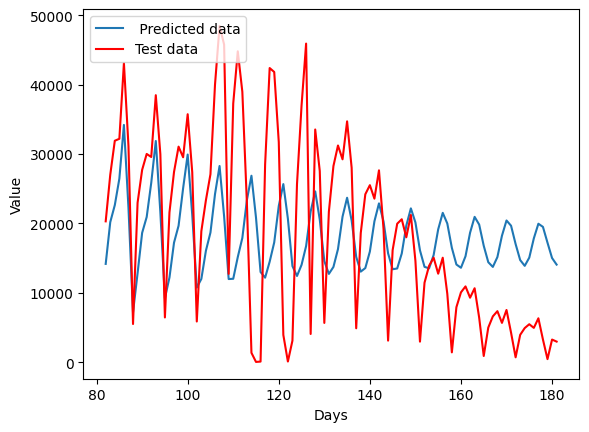

In [16]:
# Model autoregresyjny to model szeregów czasowych, który opisuje, w jaki sposób przeszłe wartości danej zmiennej wpływają 
# na jej aktualną wartość. Autoregresja czyli liniowa regresja która wykonuje się na sobie.
from statsmodels.tsa.ar_model import AutoReg

for col in ['new_confirmed', 'new_deceased', 'new_persons_vaccinated']:
    train_data = df[col][:len(df)-100]
    test_data = df[col][len(df)-100:]

    ar_model = AutoReg(train_data.astype(float), lags=7).fit()
    pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

    plt.plot(pred, label =' Predicted data')
    plt.plot(test_data, color='red', label ='Test data')
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend(loc = 2)
    plt.show()


## Dodatkowe Dane

In [17]:
# 1.1 Przygotuj dane, które będą Ci potrzebne do przewidzenia nowych przypadków COVID-19 i przefiltruj je, 
# aby uwzględnić tylko interesujący Cię okres czasu (np.rok 2022, I i II kw. 2021).
sql = """
    select
    date, new_tested, mobility_parks, mobility_grocery_and_pharmacy
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2021-09-01' and '2022-03-01'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
df2 = query_result.to_dataframe()
df2['new_tested'] = df2['new_tested'].astype(int)
df2['mobility_parks'] = df2['mobility_parks'].astype(int)
df2['mobility_grocery_and_pharmacy'] = df2['mobility_grocery_and_pharmacy'].astype(int)


df2

,date,new_tested,mobility_parks,mobility_grocery_and_pharmacy
0,2021-09-01,39273,99,38
1,2021-09-02,36549,107,33
2,2021-09-03,41135,110,29
3,2021-09-04,30119,148,18
4,2021-09-05,21322,160,101
...,...,...,...,...
177,2022-02-25,78097,15,21
178,2022-02-26,49801,26,13
179,2022-02-27,42701,28,23
180,2022-02-28,85962,15,21


In [18]:
## Prawdziwe dane do przewidywań 
sql = """
    select
    date, new_tested, mobility_parks, mobility_grocery_and_pharmacy
    from `bigquery-public-data.covid19_open_data.covid19_open_data`
    where aggregation_level = 0
    and country_name = 'Poland'
    and date between '2022-03-02' and '2022-03-29'
    order by date
"""
q1 = (sql)
query_job = client.query(q1)
query_result = query_job.result()
av = query_result.to_dataframe()

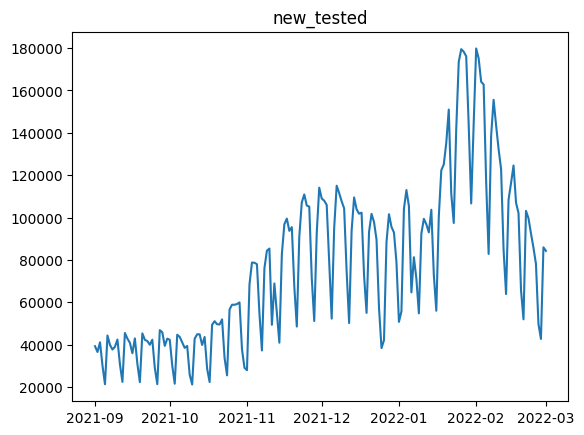

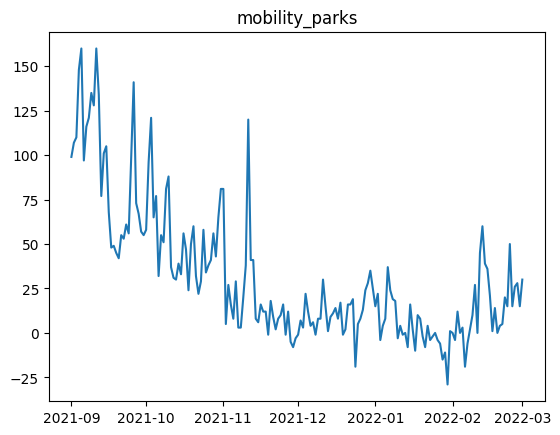

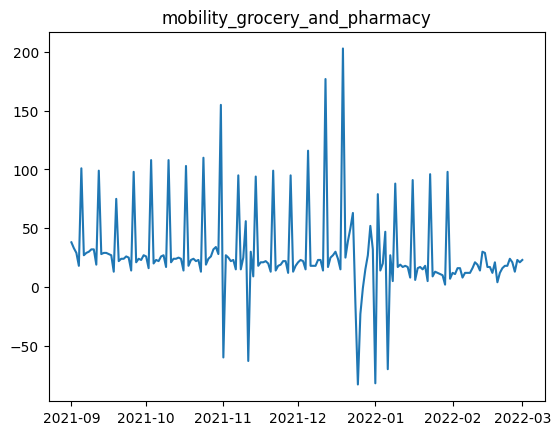

In [19]:
#Przedstawienie na wykresie pobranych danych
for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:
    plt.plot(df2['date'], df2[col], label =col)
    plt.title(col)
    plt.show()


In [20]:
#1.2 przygotowanie do analizy regresji liniowej
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import datetime as dt
df2['date'] = pd.to_datetime(df['date'])
df2['date']=df2['date'].map(dt.datetime.toordinal)
df2

,date,new_tested,mobility_parks,mobility_grocery_and_pharmacy
0,738034,39273,99,38
1,738035,36549,107,33
2,738036,41135,110,29
3,738037,30119,148,18
4,738038,21322,160,101
...,...,...,...,...
177,738211,78097,15,21
178,738212,49801,26,13
179,738213,42701,28,23
180,738214,85962,15,21


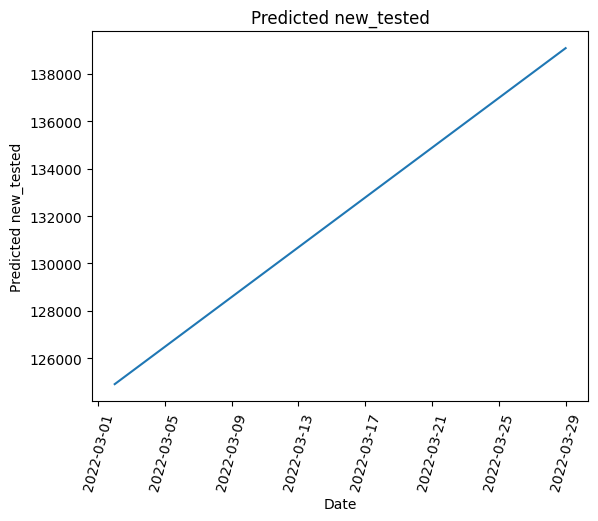

Best degree: 5


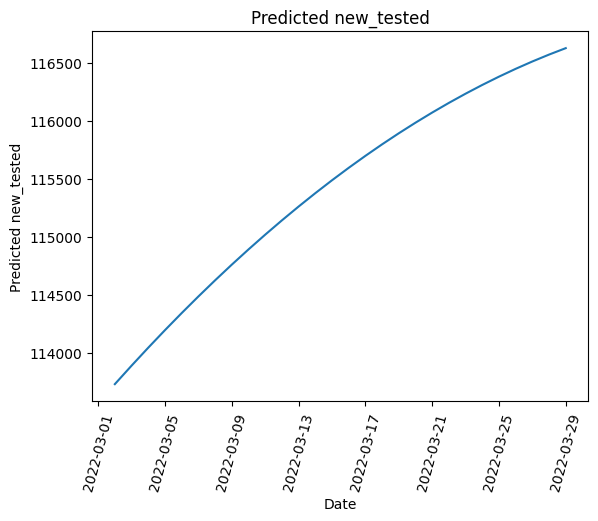

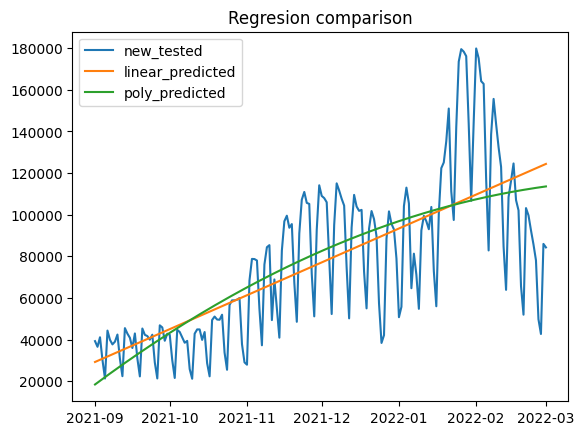

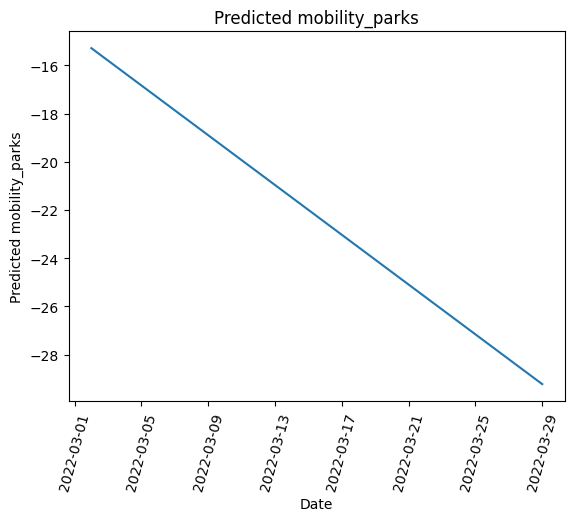

Best degree: 2


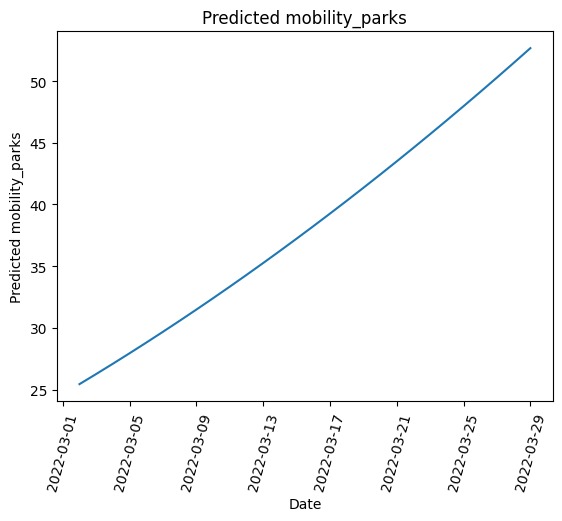

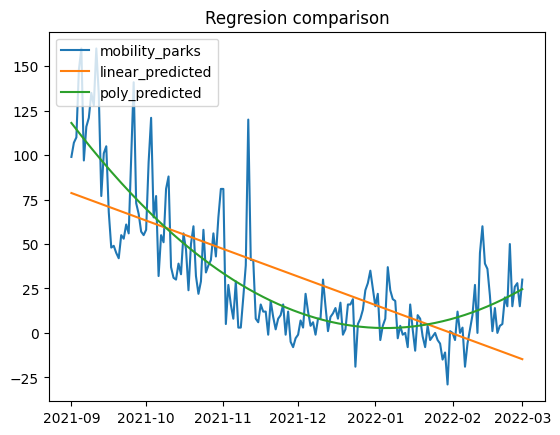

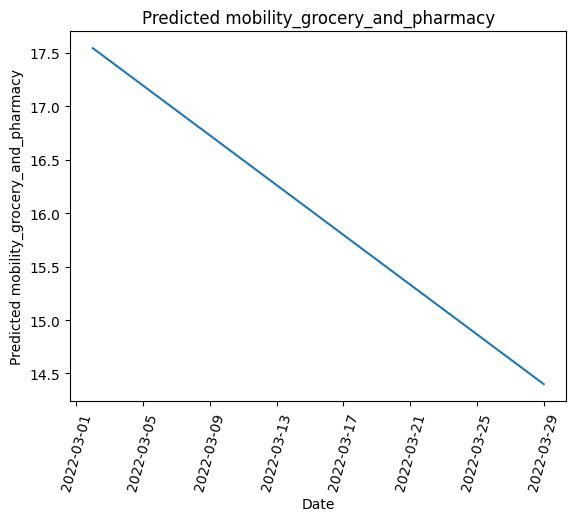

Best degree: 4


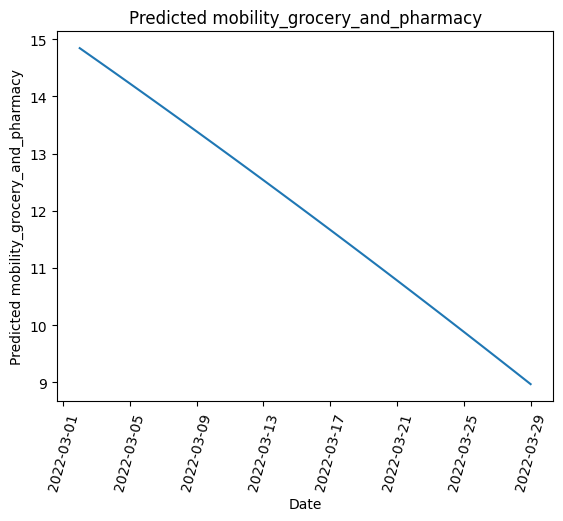

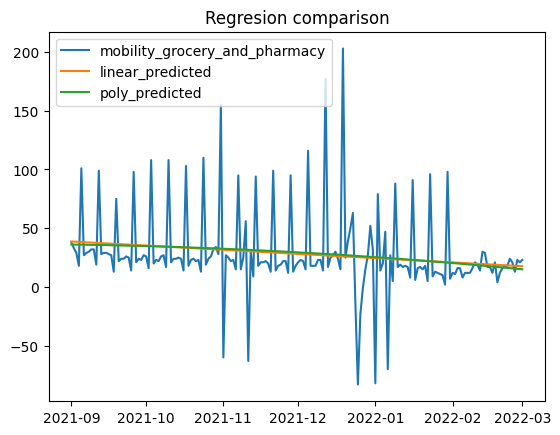

In [21]:
# wizualizacja przewidywań dla modelu liniowego i wielomianowego i wizualizacja modelu 
#dla zachorowań śmierci i szczepień

for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:
    
    p_data, lidd = linear_prediction(df2, col)
    pp_data, lidd2, pr = poly_prediction(df2, col, p_data)
    
    # wykres porównawczy
    linear_predicted = lidd.predict(df2['date'].values.reshape(-1,1))
    poly_predicted = lidd2.predict(pr.fit_transform(df2[['date']]))
    df2['date']=df2['date'].map(dt.datetime.fromordinal)
    plt.plot(df2['date'], df2[col], label = col)
    plt.plot(df2['date'], linear_predicted, label ='linear_predicted')
    plt.plot(df2['date'], poly_predicted, label ='poly_predicted')
    plt.legend(loc = 2)
    plt.title("Regresion comparison")
    plt.show()
    df2['date']=df2['date'].map(dt.datetime.toordinal)

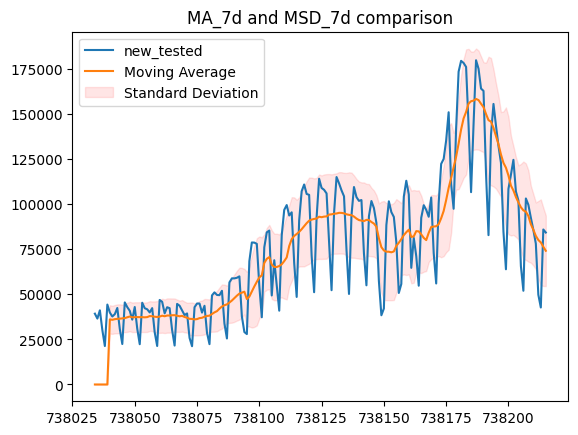

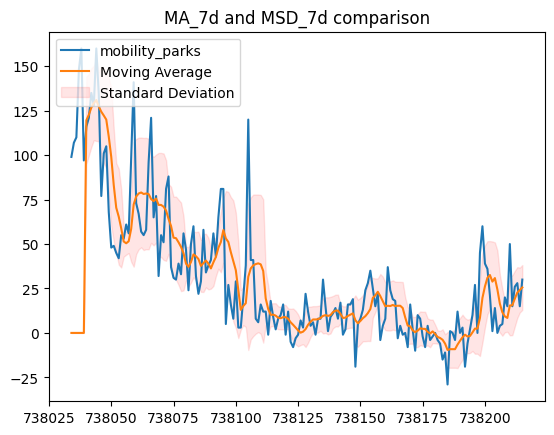

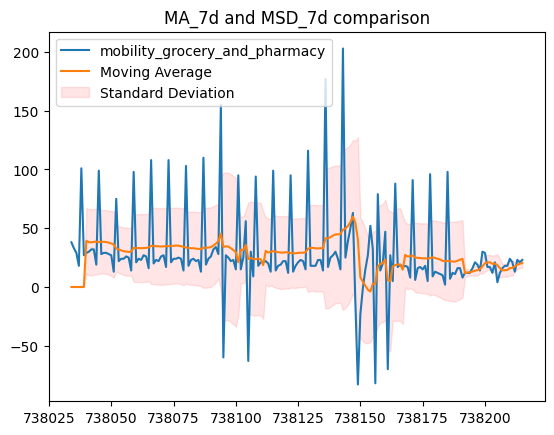

In [22]:

for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:
    #Średnia krocząca 7-dniowa
    df2['Moving_Average'] = df2[col].rolling(7).mean()

    #Odchylenie standardowe kroczace 7-dniowe
    df2['Moving_Standart_Deviation'] = df2[col].rolling(7).std()

    df2[["Moving_Average","Moving_Standart_Deviation"]] = df2[["Moving_Average","Moving_Standart_Deviation"]].fillna(0)

    plt.plot(df2['date'], df2[col], label =col)
    plt.plot(df2['date'], df2['Moving_Average'], label ='Moving Average')
    #plt.plot(df['date'], df['MSD_7d'], label ='MSD_7d')
    plt.fill_between(df2['date'], df2['Moving_Average'] - df2['Moving_Standart_Deviation'], df2['Moving_Average'] + df2['Moving_Standart_Deviation'], alpha=0.1, color ="red",  label='Standard Deviation')
    plt.legend(loc = 2)
    plt.title("MA_7d and MSD_7d comparison")
    plt.show()

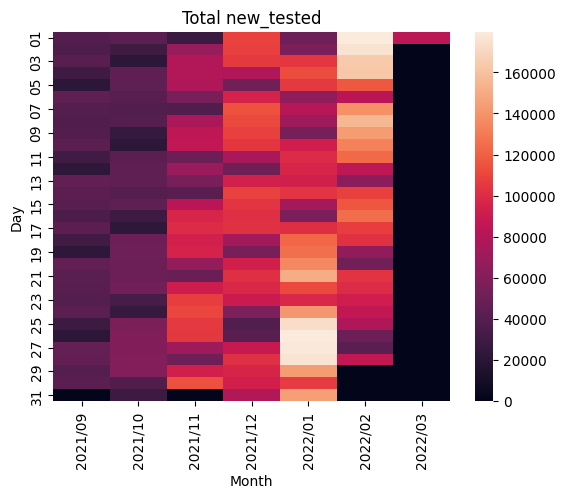

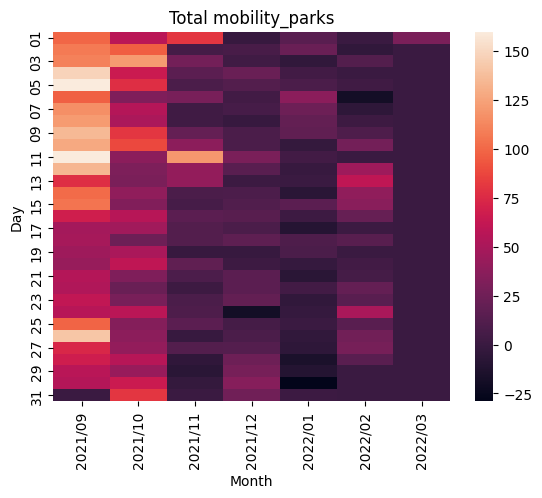

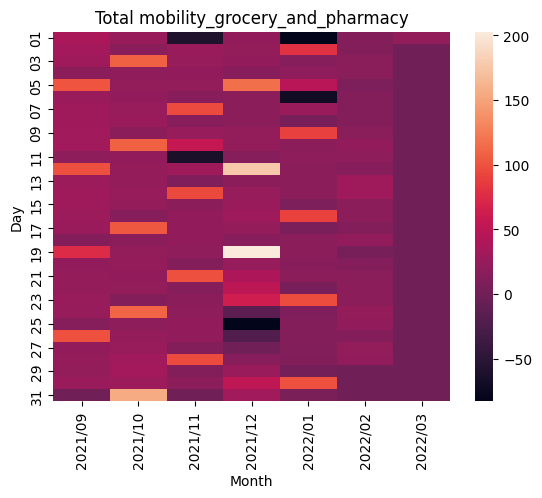

In [23]:
#heatmaps

df2['date']=df2['date'].map(dt.datetime.fromordinal)
df2['Year_Month'] = df2['date'].dt.strftime('%Y/%m')
df2['Day'] = df2['date'].dt.strftime('%d')
df2

tmp = df2.pivot_table(index="Day", columns="Year_Month", values="new_tested")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total new_tested")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df2.pivot_table(index="Day", columns="Year_Month", values="mobility_parks")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total mobility_parks")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

tmp = df2.pivot_table(index="Day", columns="Year_Month", values="mobility_grocery_and_pharmacy")
tmp = tmp.fillna(0)
tmp = tmp.astype(float)
sns.heatmap(tmp)
plt.title("Total mobility_grocery_and_pharmacy")
plt.xlabel("Month")
plt.ylabel("Day")
plt.show()

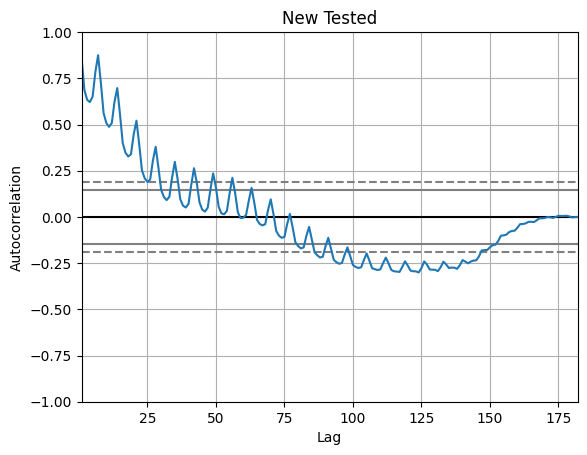

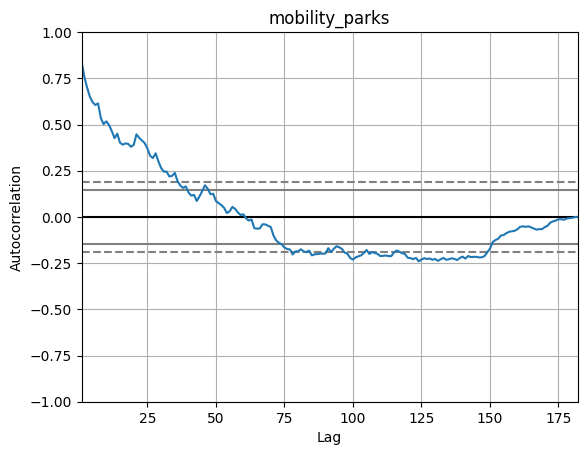

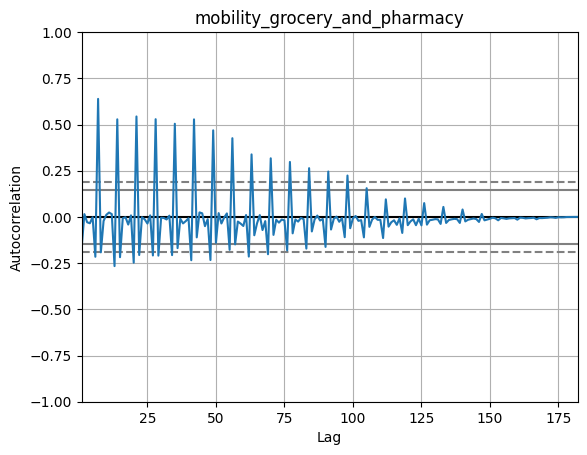

In [24]:
#2.2. Wykorzystaj do analizy trendów analizę szeregów czasowych (autoregresja, średnia ruchoma, modele autoregresyjne), 
#która umożliwi zbadanie danych zebranych w Twoich bazach w danym okresie czasu.
#for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:

import seaborn as sns
# Wykres przedstawiający autokorelacje w całym okresie
# Autokorelacja informuje nas o tym na ile dane wartości / obserwacje są istotnie związane z obserwacjami
# zaobserwowanymi wcześniej (o stałym przesunięciu czasowym).
x = pd.plotting.autocorrelation_plot(df2['new_tested'])
x.plot()
plt.title("New Tested")
plt.show()

x = pd.plotting.autocorrelation_plot(df2['mobility_parks'])
x.plot()
plt.title("mobility_parks")
plt.show()

x = pd.plotting.autocorrelation_plot(df2['mobility_grocery_and_pharmacy'])
x.plot()
plt.title("mobility_grocery_and_pharmacy")
plt.show()

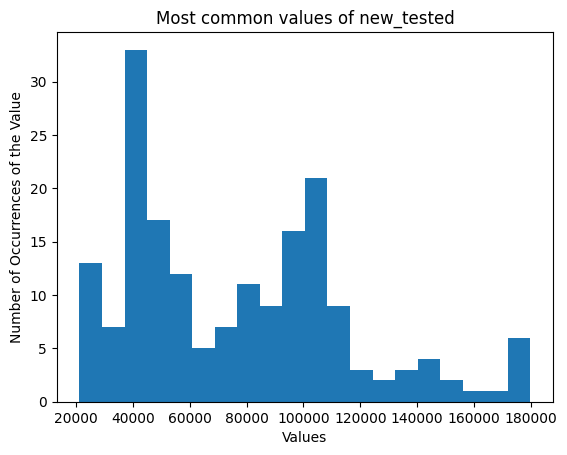

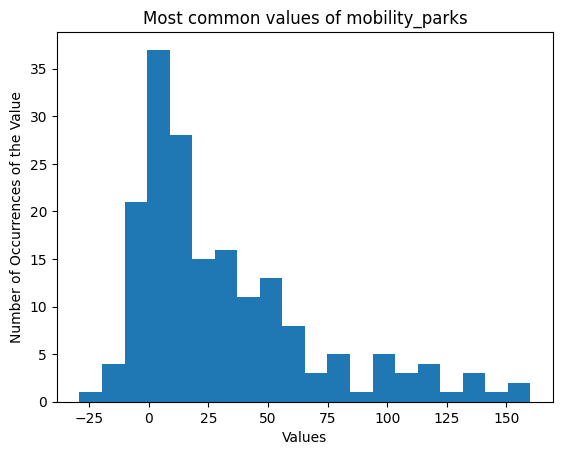

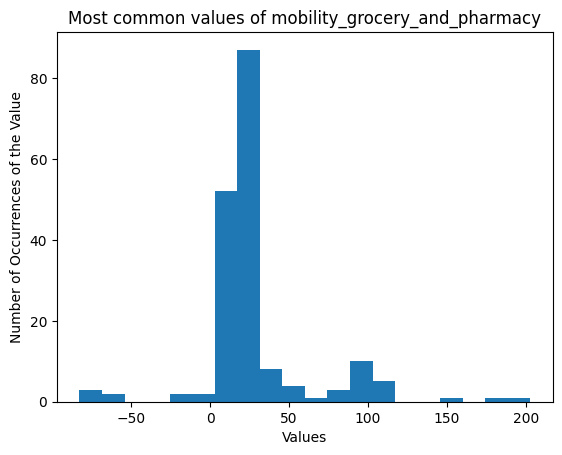

In [25]:
#Wykres rozłożenia wartosci new_confirmed

for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:
    
    plt.hist(df2[col], 20, histtype='bar')
    plt.title(f"Most common values of {col}")
    plt.xlabel("Values")
    plt.ylabel("Number of Occurrences of the Value")
    plt.show()

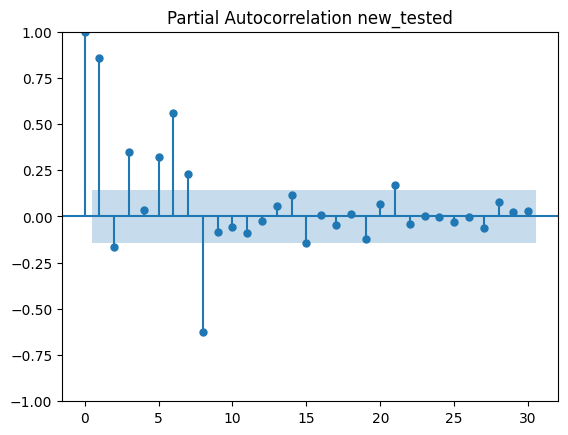

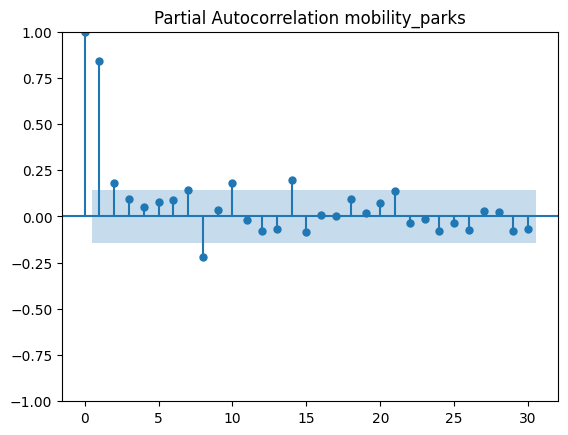

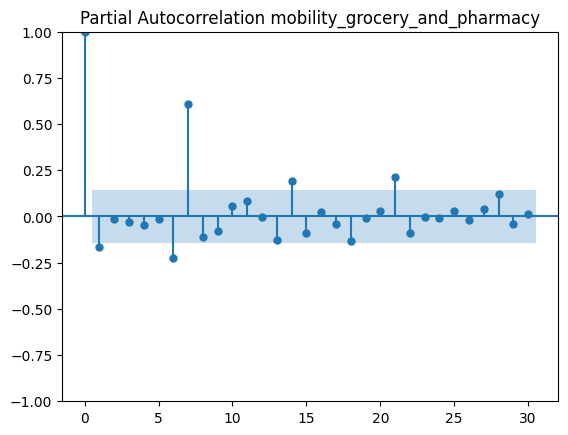

In [26]:
# Poniższy wykres może posłużyć do określenia dla jakiej wartości lags użyć autoregresji.
for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:
    pacf = plot_pacf(df2[col], lags=30)
    plt.title(f"Partial Autocorrelation {col}")
    plt.show()

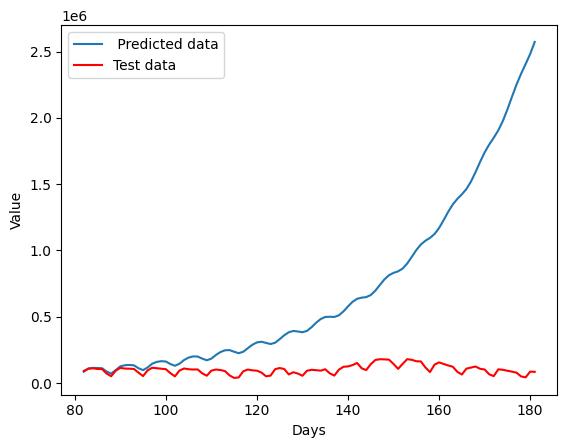

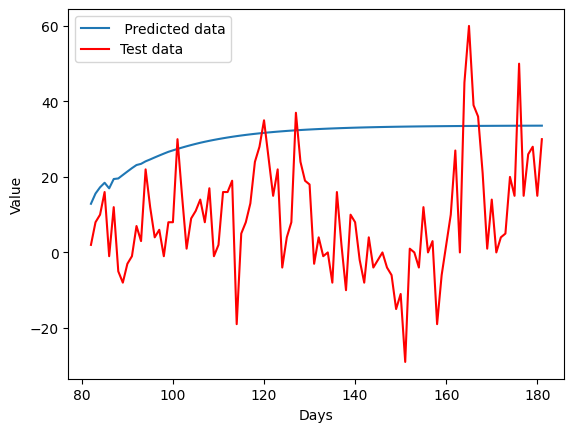

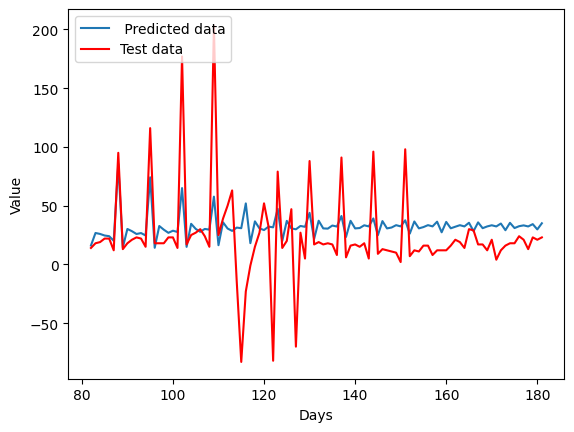

In [88]:
# Model autoregresyjny to model szeregów czasowych, który opisuje, w jaki sposób przeszłe wartości danej zmiennej wpływają 
# na jej aktualną wartość. Autoregresja czyli liniowa regresja która wykonuje się na sobie.

from statsmodels.tsa.ar_model import AutoReg

for col in ['new_tested', 'mobility_parks', 'mobility_grocery_and_pharmacy']:

    train_data = df2[col][:len(df)-100]
    test_data = df2[col][len(df)-100:]

    ar_model = AutoReg(train_data.astype(float), lags=7).fit()
    pred = ar_model.predict(start=len(train_data), end=(len(df)-1), dynamic=False)

    plt.plot(pred, label =' Predicted data')
    plt.plot(test_data, color='red', label ='Test data')
    plt.xlabel("Days")
    plt.ylabel("Value")
    plt.legend(loc = 2)
    plt.show()